Architectural innovations in deep learning occur at a breakneck pace, yet fragments of legacy code often persist, carrying assumptions and practices whose necessity remains unquestioned. Practitioners frequently accept these inherited elements as optimal by default, rarely stopping to reevaluate their continued relevance or efficiency.

Input normalization for convolutional neural networks, particularly in image processing, is a prime example of these unscrutinized practices. This is especially evident in the widespread use of pre-trained models like VGG or ResNet, where specific normalization values have become standard across the community. When consulting AI coding assistants like GitHub's Copilot, it tends to provide the following perspective:

>    Image normalization in convolutional neural networks (CNNs) has several beneficial effects:
>    1- Improved convergence: Normalization helps to stabilize and speed up the learning process by ensuring that pixel values are in a similar range, thus facilitating optimization.
>    2- Reduced sensitivity to scale variations: Normalizing images reduces the model's sensitivity to scale variations in pixel values, which can improve model robustness.
>    3- Prevention of neuron saturation: Unnormalized pixel values can lead to neuron saturation, which slows down learning. Normalization helps prevent this problem.
>    4- Improved performance: In general, image normalization can lead to better model performance in terms of accuracy and generalization.


The impact of varying input normalization values on neural network performance warrants closer examination. While conventional wisdom dictates specific normalization parameters for pre-trained models like VGG and ResNet, the fundamental properties of convolutional layers suggest these precise values may be arbitrary. Consider that:

1. The weights in the first convolutional layer are learned parameters
2. Convolution kernels can be scaled arbitrarily due to their bias terms
3. The current practice of using highly precise three-digit normalization values seems unnecessarily specific

This investigation aims to demonstrate quantitatively that the exact normalization values matter less than commonly assumed. The analysis will proceed in two parts:

1. First, examining the classic [LeNet](https://en.wikipedia.org/wiki/LeNet) architecture on the MNIST dataset
2. Then, extending the investigation to the more modern [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) architecture on ImageNet

This approach will help validate whether our rigid adherence to specific normalization values is truly justified by empirical evidence.


<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os

import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)

In [2]:
%pip install -Uq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
%mkdir -p data

## The MNIST challenge and the *French Touche* 

First, let's explore the *LeNet* network  (Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition" (PDF). Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791. S2CID 14542261), whose objective is to categorize images of written digits, one of the first great successes of Multilayer neural networks. For this one, we're going to use the classic implementation, as proposed in the PyTorch library example series. 



The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures that are applied to the database. The output accuracy value corresponds to the percentage of letters that are correctly classified.

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function, which we'll be manipulating in the course of this book.

In [4]:
# adapted from https://raw.githubusercontent.com/pytorch/examples/refs/heads/main/mnist/main.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

epochs = 15

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


def main(mean, std, weight_init=None, bias_init=None, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    if mean is None:
        transform = transforms.ToTensor()
    else:
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std,))
            ])
    dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    dataset2 = datasets.MNIST('data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if not bias_init is None:
        model.conv1.bias.data *= bias_init
    if not weight_init is None:
        model.conv1.weight.data *= weight_init

    
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'max')
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        accuracy = test(model, device, test_loader, verbose=verbose)
        scheduler.step(accuracy)

    if verbose: print(f'The std of weight and bias in the first convolutional layer is {model.conv1.weight.std().item():.4f} and  {model.conv1.bias.std().item():.4f}')
    return accuracy


(You will notice that I made minor changes, such as using the `ReduceLROnPlateau` scheduler instead of `StepLR`. In practice, this only changed the values I could test - run the notebook with enough epochs and the other scheduler to see for yourself.)

Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code, with 3-digit precision (!):

In [5]:
accuracy = main(mean=0.1307, std=0.3081, verbose=True)
print(f'{accuracy=:.4f}')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304624


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.283015


Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.449410


Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.419018


Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.119674


Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.298782


Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.012478


Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.078970


Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026963


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.015126



Test set: Average loss: 0.0458, Accuracy: 9853/10000 (99%)



Train Epoch: 2 [0/60000 (0%)]	Loss: 0.009690


Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.036890


Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080453


Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.025411


Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.072682


Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.119518


Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.007302


Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.012260


Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.015172


Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.224463



Test set: Average loss: 0.0377, Accuracy: 9880/10000 (99%)



Train Epoch: 3 [0/60000 (0%)]	Loss: 0.019473


Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.022267


Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.055717


Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.004694


Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.015216


Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.011080


Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.055859


Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.043042


Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.039513


Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.050339



Test set: Average loss: 0.0341, Accuracy: 9878/10000 (99%)



Train Epoch: 4 [0/60000 (0%)]	Loss: 0.035527


Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.042967


Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.053032


Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.108746


Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.031867


Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.001607


Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.101344


Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.143112


Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.002065


Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.056613



Test set: Average loss: 0.0346, Accuracy: 9883/10000 (99%)



Train Epoch: 5 [0/60000 (0%)]	Loss: 0.006460


Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.026735


Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.153435


Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.011361


Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.017374


Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.021547


Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.096140


Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.008092


Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.062893


Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.085981



Test set: Average loss: 0.0328, Accuracy: 9910/10000 (99%)



Train Epoch: 6 [0/60000 (0%)]	Loss: 0.013017


Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001354


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.019247


Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.020852


Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.015082


Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.024418


Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.007286


Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.005078


Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000859


Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.028109



Test set: Average loss: 0.0294, Accuracy: 9909/10000 (99%)



Train Epoch: 7 [0/60000 (0%)]	Loss: 0.066695


Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.042793


Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001904


Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.062568


Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000373


Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.115202


Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.001158


Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.033834


Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.028059


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.061778



Test set: Average loss: 0.0286, Accuracy: 9918/10000 (99%)



Train Epoch: 8 [0/60000 (0%)]	Loss: 0.025217


Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.012644


Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000435


Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.002410


Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.014255


Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.013863


Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.019356


Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.056518


Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.012160


Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.064319



Test set: Average loss: 0.0339, Accuracy: 9917/10000 (99%)



Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000096


Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.006632


Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.015303


Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.048895


Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001787


Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.054752


Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.002465


Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.151992


Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.084773


Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000669



Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99%)



Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000600


Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.017703


Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000361


Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000493


Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.150013


Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.100518


Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.058579


Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.006691


Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.046871


Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.034335



Test set: Average loss: 0.0332, Accuracy: 9912/10000 (99%)



Train Epoch: 11 [0/60000 (0%)]	Loss: 0.002855


Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.002634


Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.003255


Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.002356


Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.000976


Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.000287


Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.022203


Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.001430


Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.017498


Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.000888



Test set: Average loss: 0.0352, Accuracy: 9917/10000 (99%)



Train Epoch: 12 [0/60000 (0%)]	Loss: 0.019415


Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.056180


Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.002348


Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.000316


Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.005727


Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.013301


Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.006412


Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.002067


Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.001465


Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.024198



Test set: Average loss: 0.0410, Accuracy: 9891/10000 (99%)



Train Epoch: 13 [0/60000 (0%)]	Loss: 0.061329


Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.011598


Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.002729


Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.009479


Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.000018


Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.000573


Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.000933


Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.002803


Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.000202


Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.003094



Test set: Average loss: 0.0358, Accuracy: 9915/10000 (99%)



Train Epoch: 14 [0/60000 (0%)]	Loss: 0.071348


Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.000540


Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.008281


Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.082686


Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.000140


Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.008384


Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.004008


Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.109096


Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.002010


Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.006523



Test set: Average loss: 0.0372, Accuracy: 9894/10000 (99%)



Train Epoch: 15 [0/60000 (0%)]	Loss: 0.003454


Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.005432


Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.073258


Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.122050


Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.000063


Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.000196


Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.005263


Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.019807


Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.004439


Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.002731



Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99%)

The std of weight and bias in the first convolutional layer is 0.2256 and  0.1024
accuracy=0.9901


For image normalization in LeNet  the standard values used are for ImageNet training:

* `mean=0.1307`, 
* `std=0.3081`

These exact same numbers were first introduced in that code on [Jan 17, 2017](https://github.com/pytorch/examples/commit/32c7386aef93737926069ee284d827f8e954e086) and these exact values have not changed since (up to the 3rd digit).

What is less known is that they may be retrieved from te datasets' statistics:

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def compute_dataset_stats(dataset, batch_size=256, num_workers=4):
    """
    Calculate the channel-wise mean and standard deviation of a data set
    
    Args:
        dataset: the dataset to compute the statistics from
        batch_size: Batch size for loading data
        num_workers: Number of worker processes to load data
    
    Returns:
        Means: Means per channel
        stds: Channel-wise standard deviations
    """

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False
    )
    
    # Initialize variables for computing means
    mean = torch.zeros(3)
    mean_squared = torch.zeros(3)
    total_batches = 0
    
    print("Computing mean and standard deviation...")
    # First pass: compute mean
    for images, _ in tqdm(loader):
        # print(images.size()) # B x C x H x W
        # batch_samples = images.size(0)
        mean += images.mean(dim=(0, -2, -1))
        mean_squared += ((images - images.mean(dim=(0, -2, -1), keepdim=True))**2).mean(dim=(0, -2, -1))
        total_batches += 1
    
    mean = mean / total_batches
    std = torch.sqrt(mean_squared / total_batches)
    
    return mean, std


dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
means, stds = compute_dataset_stats(dataset)

print("MNIST stats on the train set:")
print(f"Mean: {means[0]:.4f}")
print(f"Std: {stds[0]:.4f}")


dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
means, stds = compute_dataset_stats(dataset)

print("MNIST stats on the test set:")
print(f"Mean: {means[0]:.4f}")
print(f"Std: {stds[0]:.4f}")

Computing mean and standard deviation...


  0%|                                                                                                | 0/235 [00:00<?, ?it/s]

  9%|████████                                                                              | 22/235 [00:00<00:01, 211.20it/s]

 33%|████████████████████████████▌                                                         | 78/235 [00:00<00:00, 397.93it/s]

 50%|██████████████████████████████████████████▋                                          | 118/235 [00:00<00:00, 324.82it/s]

 67%|████████████████████████████████████████████████████████▊                            | 157/235 [00:00<00:00, 340.55it/s]

 84%|███████████████████████████████████████████████████████████████████████▎             | 197/235 [00:00<00:00, 353.30it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▎| 233/235 [00:00<00:00, 324.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 323.93it/s]

MNIST stats on the train set:
Mean: 0.1306
Std: 0.3079
Computing mean and standard deviation...


  0%|                                                                                                 | 0/40 [00:00<?, ?it/s]

 28%|████████████████████████▏                                                               | 11/40 [00:00<00:00, 96.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 191.26it/s]

MNIST stats on the test set:
Mean: 0.1332
Std: 0.3110


The core idea here is that we train a network for given values so that whenever we feed in new input values, such as from the validation set, the batch will have similar first-order statistics. But is this hypothesis really important given the architecture of the network? 

Our implementation offers the flexibility to experiment with different normalization values (mean and standard deviation), allowing us to verify whether changing these initial parameters impacts the model's accuracy.

This way we can empirically test if the commonly used normalization values are truly special or if the network performs similarly with different normalization parameters.

Let's first see what happens without normalization:

In [7]:
accuracy = main(mean=None, std=None)
print(f'{accuracy=:.4f}')

accuracy=0.9900


Pretty much the same... but slightly better.

What if we use standard numbers?

In [8]:
accuracy = main(mean=0., std=1.)
print(f'{accuracy=:.4f}')

accuracy=0.9914


The result seems similar, but it's not enough to demonstrate that the mean and standard deviation have no effect on learning.

### computing accuracy on a regular grid of values

I'm now going to push the boat out further, using a library that allows me to test several values and thus optimize the parameters. If the mean and deviation are so important, we'll converge on a fixed set of values, whereas if they're less important, the values can be quite scattered. In particular, this will allow us to choose an arbitrary value, such as a mean of 0 and a standard deviation of 1, better known as *normal* normalization.

In [9]:
model = 'LeNet'
epochs = 30 # a bit more than the original example which had 15 epochs
N_scan = 15

means = np.linspace(-2, 3., N_scan, endpoint=True)
stds = np.geomspace(0.02, 2., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
# %rm {path_save_numpy}
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean=mean, std=std, epochs=epochs)
    np.save(path_save_numpy, accuracy)
else:
    print(f'Loading {path_save_numpy}')
    accuracy = np.load(path_save_numpy)    

Loading numpy-LeNet.npy


/tmp/ipykernel_531714/4244923449.py:2: UserWarning: The following kwargs were not used by contour: 'n'
  CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')


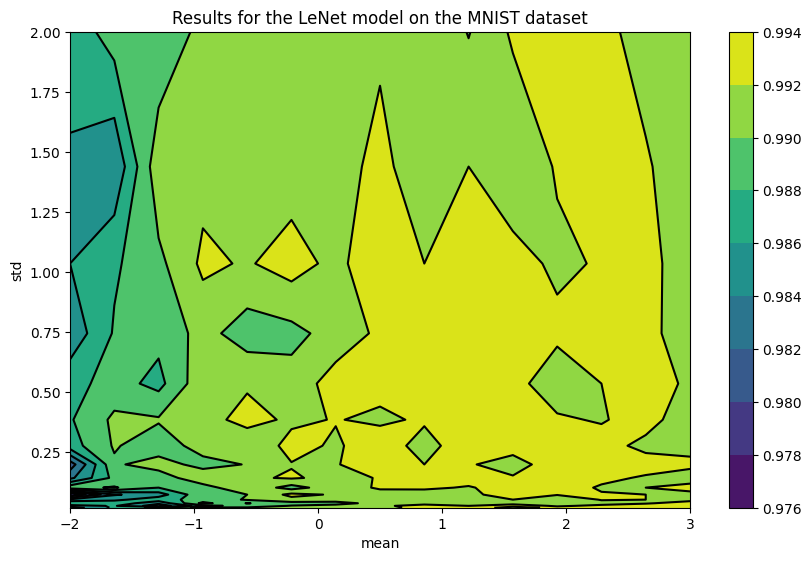

In [10]:
fig, ax = plt.subplots(figsize=figsize)
CS = ax.contourf(means, stds, accuracy, n=20, cmap='viridis')
CS2 = ax.contour(CS, levels=CS.levels, colors='k')
fig.colorbar(CS, ax=ax, extendfrac=0)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

One is most certainly interested by the best value:

In [11]:
mean_max, std_max = np.unravel_index(np.argmax(accuracy), accuracy.shape)
print(f'Optimal value at indicies {mean_max, std_max}, with accuracy {accuracy[mean_max, std_max]:.4f}')

Optimal value at indicies (12, 7), with accuracy 0.9936


In [12]:
print(f'Optimal value: of mean={means[mean_max]:.4f}, std={stds[std_max]:.4f}')

Optimal value: of mean=2.2857, std=0.2000


Or by the barycenter of the accuracy map:

In [13]:
print(f'Center of gravity: {np.sum(means*accuracy)/np.sum(accuracy):.4f}, {np.sum(stds*accuracy)/np.sum(accuracy):.4f}')

Center of gravity: 0.5026, 0.4728


There is a low variabilty of the accuracy:

In [14]:
print(f'Variabity of accuracy: {np.std(accuracy):.4f}')

Variabity of accuracy: 0.0025


Mostly driven by the worst value:

In [15]:
mean_min, std_min = np.unravel_index(np.argmin(accuracy), accuracy.shape)
accuracy_min = accuracy[mean_min, std_min]
print(f'Worst value at indices {mean_min, std_min}, with accuracy {accuracy_min:.4f}')

Worst value at indices (4, 0), with accuracy 0.9779


In [16]:
print(f'Worst value: of mean={means[mean_min]:.4f}, std={stds[std_min]:.4f}')

Worst value: of mean=-0.5714, std=0.0200


The variability on the plateau is very low:

In [17]:
accuracy_best95 = accuracy[accuracy >np.percentile(accuracy, .05)].flatten()
print(f'Mean of accuracy for the best 95%: {np.mean(accuracy_best95):.4f}')
print(f'Variabity of accuracy for the best 95%: {np.std(accuracy_best95):.4f}')

Mean of accuracy for the best 95%: 0.9908
Variabity of accuracy for the best 95%: 0.0023


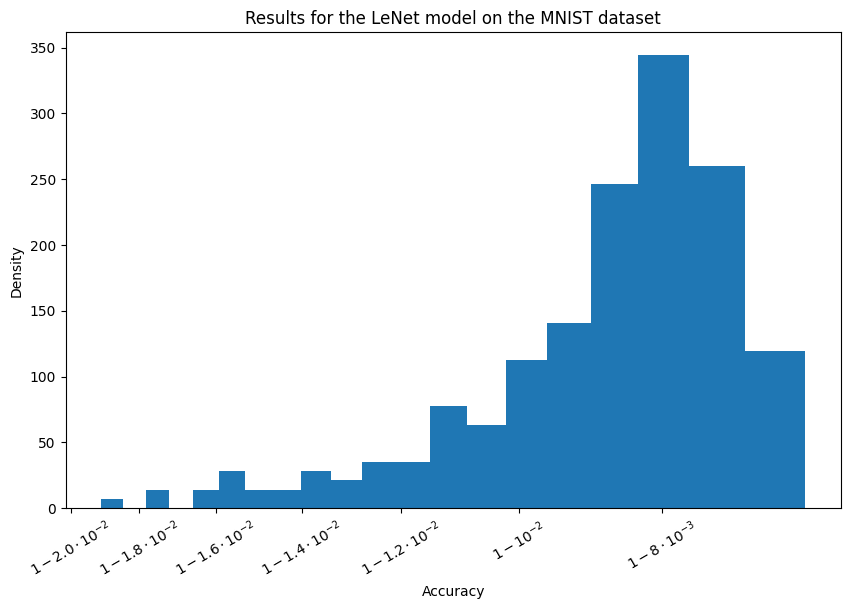

In [18]:
fig, ax = plt.subplots(figsize=figsize)
ax.hist(accuracy_best95, bins=20, density=True)
ax.set_title('Results for the LeNet model on the MNIST dataset')
ax.set_xlabel('Accuracy')
ax.set_xscale('logit')
plt.xticks(rotation=30)
ax.set_ylabel('Density')
fig;

Such that we can confidently say that we do not need a 3 digits initialization

In [19]:
accuracy = main(mean=0.5, std=0.5, verbose=False)
print(f'{accuracy=:.4f}')

accuracy=0.9915


### Optimizing Normalization Parameters with Optuna
To more rigorously test our hypothesis about normalization parameters, we'll employ Optuna, a hyperparameter optimization library. This approach will allow us to:

1. Explore a diverse range of normalization values systematically
2. Test whether optimization converges to specific values (suggesting their importance) or remains scattered (suggesting flexibility)
3. Compare performance with standard normal normalization (`mean = 0`, `std = 1`)

The non-regular grid search capability of Optuna is particularly valuable here, as it can help reveal whether the commonly used precise normalization values are truly optimal or if equivalent performance can be achieved across a broader range of parameters.

In [20]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [21]:
path_save_optuna =  f'optuna-{model}.sqlite3'
print(f'-> file {path_save_optuna} exists: {os.path.isfile(path_save_optuna)}')

-> file optuna-LeNet.sqlite3 exists: True


In [22]:
n_trials = 200

In [23]:
# %rm {path_save_optuna}

In [24]:
def objective(trial):
    mean = trial.suggest_float('mean', -1, 2., log=False)
    std = trial.suggest_float('std', 0.05, 1., log=True)
    accuracy = main(mean=mean, std=std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.1440116283993092, 'std': 0.5690034868978842}
Best value:  0.9935


/tmp/ipykernel_531714/2318167149.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-28 10:45:08,434] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


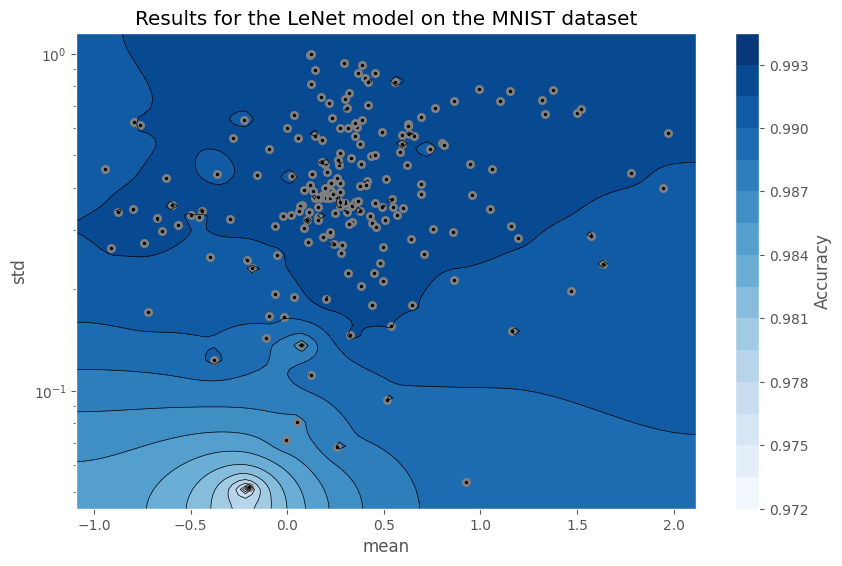

In [25]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
fig = plt.gcf()
ax.set_title('Results for the LeNet model on the MNIST dataset')
fig.set_size_inches(figsize[0], figsize[1])

The observed pattern raises several interconnected questions about the network's design and behavior:

1. The Redundancy Puzzle :  Why do specific normalization values appear to matter when multiple mechanisms exist to compensate for input scaling? These mechanisms include: 
    1. Adjustable bias terms
    2. Learnable weight scaling
    3. Batch normalization layers

2. The Historical Values Questio: n What was the original process for determining these widely-used normalization parameters? Are they truly optimal, or simply the first values that worked well enough?

3. The Initialization Mystery: 

How are the weights and biases in these layers initialized by default?
What is the relationship between initialization schemes and input normalization?


These questions suggest that the interaction between input normalization, layer initialization, and network adaptation might be more complex than commonly assumed. 

For [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [nn.conv2D](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.Conv2d.html), the weights are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in\_features}}$ for the linear layer and $k = \frac{1}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}$.

This is done by [Glorot initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) :


In [26]:
conv1 = nn.Conv2d(1, 32, 3, 1)
print(f'The mean of weight and bias in the first convolutional layer is {conv1.weight.mean().item():.4f} and  {conv1.bias.mean().item():.4f}')
print(f'The std of weight and bias in the first convolutional layer is {conv1.weight.std().item():.4f} and  {conv1.bias.std().item():.4f}')
print(f' k= {1/3/3/1:.4f}, sqrt(k) = {np.sqrt(1/3/3/1):.4f}$')


The mean of weight and bias in the first convolutional layer is 0.0212 and  0.0181
The std of weight and bias in the first convolutional layer is 0.1869 and  0.1941
 k= 0.1111, sqrt(k) = 0.3333$


### using optuna to search for another initialization point


A few open questions remain: Why do these values matter when we have multiple compensatory mechanisms (bias values, weight scaling, batch normalization)? How were these normalization parameters historically determined?
How are the layer weights and biases initialized by default, and what is their relationship with input normalization?

Let's see if for a given value for which we know the accuracy was worst (`mean=mean_min` and `std=std_min`), we can optimize the bias and weight intialization to get a better value, like that of the 95% best values obtained.


In [27]:
def objective(trial):
    weight_init = trial.suggest_float('weight_init', 0.05, 20., log=True)
    bias_init = trial.suggest_float('bias_init', 0.05, 20., log=True)
    accuracy = main(mean=-1, std=0.1, weight_init=weight_init, bias_init=bias_init, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-init_WB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'weight_init': 0.307155100974441, 'bias_init': 5.5455929037599185}
Best value:  0.9941


So there's a clear  **yes** as we increase from the minimum value to a value exceeding the 95th percentile of the previously computed range.


In [28]:
print(f'Mean of accuracy for the best 95%: {np.mean(accuracy_best95):.4f}')
print(f'Variabity of accuracy for the best 95%: {np.std(accuracy_best95):.4f}')

Mean of accuracy for the best 95%: 0.9908
Variabity of accuracy for the best 95%: 0.0023


## The ImageNet challenge and *residual networks* 

Second, let's tackle a real world problem: image classification with 1 million images and 1000 labels. For this we will use the well-known Resnet model defined in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) as it givves a nice balance between simplicity and performance. In general, [Residual neural networks](https://en.wikipedia.org/wiki/Residual_neural_network) are widely used architectures for feed-forward networks appliead to image categorization. 


https://pytorch.org/hub/pytorch_vision_resnet/

In [29]:
import torch
from torchvision.models import ResNet18_Weights

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
# or any of these variants 'resnet34', 'resnet50', 'resnet101', 'resnet152',
model

Using cache found in /home/laurent/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

For image normalization in ResNet (and many other computer vision models), the standard values used are for ImageNet training:

* Mean: `[0.485, 0.456, 0.406]` (for R,G,B channels respectively)
* Std: `[0.229, 0.224, 0.225]`

And which may be retrieved from te datasets' statistics:

In [30]:
import socket
print(socket.gethostname())

CONECT-LID-01


In [31]:
if socket.gethostname() == 'CONECT-LID-01': # at the lab
    DATADIR = '/home/laurent/app54_nextcloud/2024_archives/2024_science/Deep_learning/data/Imagenet_full'
    DATADIR = '../Deep_learning/data/Imagenet_redux'
else:
    DATADIR = '/Volumes/SSD1TO/Deep_learning/data/Imagenet_full'
    DATADIR = '/Volumes/SSD1TO/Deep_learning/data/Imagenet_redux'

In [32]:
# Replace with your ImageNet data path
# Only transform to tensor and divide by 255
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()  # Scales data to [0,1]
])

for type in ['train', 'val']:
    dataset = torchvision.datasets.ImageFolder(f"{DATADIR}/{type}", transform=transform)
    means, stds = compute_dataset_stats(dataset)
    print(f"\nImageNet stats on the {type} set:")
    print(f"Means: R-{means[0]:.4f} G-{means[1]:.4f} B-{means[2]:.4f}")
    print(f"Stds: R-{stds[0]:.4f} G-{stds[1]:.4f} B-{stds[2]:.4f}")


Computing mean and standard deviation...


  0%|                                                                                                | 0/391 [00:00<?, ?it/s]

  0%|▏                                                                                       | 1/391 [00:00<05:13,  1.24it/s]

  1%|▋                                                                                       | 3/391 [00:00<01:36,  4.02it/s]

  1%|█▏                                                                                      | 5/391 [00:01<01:38,  3.93it/s]

  2%|█▌                                                                                      | 7/391 [00:01<01:10,  5.47it/s]

  2%|██                                                                                      | 9/391 [00:02<01:20,  4.74it/s]

  3%|██▍                                                                                    | 11/391 [00:02<01:04,  5.89it/s]

  3%|██▉                                                                                    | 13/391 [00:02<01:19,  4.78it/s]

  4%|███▎                                                                                   | 15/391 [00:03<01:02,  6.02it/s]

  4%|███▌                                                                                   | 16/391 [00:03<00:59,  6.33it/s]

  4%|███▊                                                                                   | 17/391 [00:03<01:23,  4.46it/s]

  5%|████                                                                                   | 18/391 [00:03<01:28,  4.21it/s]

  5%|████▍                                                                                  | 20/391 [00:04<01:00,  6.11it/s]

  5%|████▋                                                                                  | 21/391 [00:04<01:16,  4.82it/s]

  6%|████▉                                                                                  | 22/391 [00:04<01:36,  3.81it/s]

  6%|█████▎                                                                                 | 24/391 [00:04<01:04,  5.66it/s]

  7%|█████▊                                                                                 | 26/391 [00:05<01:26,  4.24it/s]

  7%|██████▏                                                                                | 28/391 [00:05<01:02,  5.77it/s]

  8%|██████▋                                                                                | 30/391 [00:06<01:22,  4.39it/s]

  8%|███████                                                                                | 32/391 [00:06<01:01,  5.83it/s]

  9%|███████▌                                                                               | 34/391 [00:07<01:18,  4.55it/s]

  9%|████████                                                                               | 36/391 [00:07<00:59,  5.97it/s]

 10%|████████▍                                                                              | 38/391 [00:07<01:15,  4.67it/s]

 10%|████████▉                                                                              | 40/391 [00:07<00:58,  6.05it/s]

 11%|█████████▎                                                                             | 42/391 [00:08<01:14,  4.68it/s]

 11%|█████████▊                                                                             | 44/391 [00:08<00:57,  6.03it/s]

 12%|██████████▏                                                                            | 46/391 [00:09<01:17,  4.44it/s]

 12%|██████████▋                                                                            | 48/391 [00:09<00:59,  5.79it/s]

 13%|███████████▏                                                                           | 50/391 [00:10<01:15,  4.52it/s]

 13%|███████████▌                                                                           | 52/391 [00:10<00:57,  5.86it/s]

 14%|████████████                                                                           | 54/391 [00:10<01:11,  4.70it/s]

 14%|████████████▍                                                                          | 56/391 [00:11<00:54,  6.10it/s]

 15%|████████████▉                                                                          | 58/391 [00:11<01:04,  5.15it/s]

 15%|█████████████▎                                                                         | 60/391 [00:11<00:50,  6.60it/s]

 16%|█████████████▊                                                                         | 62/391 [00:12<00:59,  5.54it/s]

 16%|██████████████▏                                                                        | 64/391 [00:12<00:46,  7.01it/s]

 17%|██████████████▋                                                                        | 66/391 [00:12<00:56,  5.71it/s]

 17%|███████████████▏                                                                       | 68/391 [00:12<00:44,  7.21it/s]

 18%|███████████████▌                                                                       | 70/391 [00:13<00:59,  5.39it/s]

 18%|████████████████                                                                       | 72/391 [00:13<00:46,  6.84it/s]

 19%|████████████████▍                                                                      | 74/391 [00:14<00:58,  5.44it/s]

 19%|████████████████▉                                                                      | 76/391 [00:14<00:45,  6.90it/s]

 20%|█████████████████▎                                                                     | 78/391 [00:14<00:55,  5.59it/s]

 20%|█████████████████▊                                                                     | 80/391 [00:14<00:44,  7.05it/s]

 21%|██████████████████▏                                                                    | 82/391 [00:15<00:57,  5.39it/s]

 21%|██████████████████▋                                                                    | 84/391 [00:15<00:45,  6.82it/s]

 22%|███████████████████▏                                                                   | 86/391 [00:16<00:54,  5.57it/s]

 23%|███████████████████▌                                                                   | 88/391 [00:16<00:43,  7.01it/s]

 23%|████████████████████                                                                   | 90/391 [00:16<00:48,  6.19it/s]

 24%|████████████████████▍                                                                  | 92/391 [00:16<00:38,  7.70it/s]

 24%|████████████████████▉                                                                  | 94/391 [00:17<00:58,  5.12it/s]

 25%|█████████████████████▎                                                                 | 96/391 [00:17<00:45,  6.51it/s]

 25%|█████████████████████▊                                                                 | 98/391 [00:18<00:56,  5.23it/s]

 26%|█████████████████████▉                                                                | 100/391 [00:18<00:43,  6.70it/s]

 26%|██████████████████████▍                                                               | 102/391 [00:18<00:53,  5.42it/s]

 27%|██████████████████████▊                                                               | 104/391 [00:18<00:41,  6.92it/s]

 27%|███████████████████████▎                                                              | 106/391 [00:19<00:56,  5.09it/s]

 28%|███████████████████████▊                                                              | 108/391 [00:19<00:43,  6.49it/s]

 28%|████████████████████████▏                                                             | 110/391 [00:20<00:54,  5.17it/s]

 29%|████████████████████████▋                                                             | 112/391 [00:20<00:42,  6.60it/s]

 29%|█████████████████████████                                                             | 114/391 [00:20<00:55,  5.03it/s]

 30%|█████████████████████████▌                                                            | 116/391 [00:20<00:42,  6.41it/s]

 30%|█████████████████████████▉                                                            | 118/391 [00:21<00:54,  4.97it/s]

 31%|██████████████████████████▍                                                           | 120/391 [00:21<00:42,  6.36it/s]

 31%|██████████████████████████▊                                                           | 122/391 [00:22<00:56,  4.75it/s]

 32%|███████████████████████████▎                                                          | 124/391 [00:22<00:43,  6.08it/s]

 32%|███████████████████████████▋                                                          | 126/391 [00:23<00:56,  4.66it/s]

 33%|████████████████████████████▏                                                         | 128/391 [00:23<00:43,  6.00it/s]

 33%|████████████████████████████▌                                                         | 130/391 [00:23<00:53,  4.86it/s]

 34%|█████████████████████████████                                                         | 132/391 [00:23<00:41,  6.23it/s]

 34%|█████████████████████████████▍                                                        | 134/391 [00:24<00:50,  5.09it/s]

 35%|█████████████████████████████▉                                                        | 136/391 [00:24<00:39,  6.48it/s]

 35%|██████████████████████████████▎                                                       | 138/391 [00:25<00:47,  5.31it/s]

 36%|██████████████████████████████▊                                                       | 140/391 [00:25<00:37,  6.72it/s]

 36%|███████████████████████████████▏                                                      | 142/391 [00:25<00:46,  5.35it/s]

 37%|███████████████████████████████▋                                                      | 144/391 [00:25<00:36,  6.80it/s]

 37%|████████████████████████████████                                                      | 146/391 [00:26<00:46,  5.25it/s]

 38%|████████████████████████████████▌                                                     | 148/391 [00:26<00:36,  6.68it/s]

 38%|████████████████████████████████▉                                                     | 150/391 [00:27<00:46,  5.15it/s]

 39%|█████████████████████████████████▍                                                    | 152/391 [00:27<00:36,  6.57it/s]

 39%|█████████████████████████████████▊                                                    | 154/391 [00:27<00:47,  5.00it/s]

 40%|██████████████████████████████████▌                                                   | 157/391 [00:28<00:40,  5.77it/s]

 40%|██████████████████████████████████▊                                                   | 158/391 [00:28<00:45,  5.07it/s]

 41%|███████████████████████████████████▍                                                  | 161/391 [00:29<00:41,  5.56it/s]

 41%|███████████████████████████████████▋                                                  | 162/391 [00:29<00:43,  5.23it/s]

 42%|████████████████████████████████████                                                  | 164/391 [00:29<00:33,  6.71it/s]

 42%|████████████████████████████████████▎                                                 | 165/391 [00:29<00:44,  5.05it/s]

 42%|████████████████████████████████████▌                                                 | 166/391 [00:30<00:42,  5.36it/s]

 43%|████████████████████████████████████▉                                                 | 168/391 [00:30<00:30,  7.27it/s]

 43%|█████████████████████████████████████▍                                                | 170/391 [00:30<00:42,  5.25it/s]

 44%|█████████████████████████████████████▊                                                | 172/391 [00:30<00:31,  6.87it/s]

 45%|██████████████████████████████████████▎                                               | 174/391 [00:31<00:42,  5.13it/s]

 45%|██████████████████████████████████████▋                                               | 176/391 [00:31<00:32,  6.68it/s]

 46%|███████████████████████████████████████▏                                              | 178/391 [00:32<00:44,  4.75it/s]

 46%|███████████████████████████████████████▌                                              | 180/391 [00:32<00:34,  6.15it/s]

 47%|████████████████████████████████████████                                              | 182/391 [00:32<00:39,  5.27it/s]

 47%|████████████████████████████████████████▍                                             | 184/391 [00:32<00:30,  6.73it/s]

 48%|████████████████████████████████████████▉                                             | 186/391 [00:33<00:39,  5.17it/s]

 48%|█████████████████████████████████████████▎                                            | 188/391 [00:33<00:30,  6.60it/s]

 49%|█████████████████████████████████████████▊                                            | 190/391 [00:34<00:36,  5.46it/s]

 49%|██████████████████████████████████████████▏                                           | 192/391 [00:34<00:28,  6.92it/s]

 50%|██████████████████████████████████████████▋                                           | 194/391 [00:34<00:36,  5.40it/s]

 50%|███████████████████████████████████████████                                           | 196/391 [00:34<00:28,  6.81it/s]

 51%|███████████████████████████████████████████▌                                          | 198/391 [00:35<00:35,  5.46it/s]

 51%|███████████████████████████████████████████▉                                          | 200/391 [00:35<00:27,  6.89it/s]

 52%|████████████████████████████████████████████▍                                         | 202/391 [00:36<00:34,  5.46it/s]

 52%|████████████████████████████████████████████▊                                         | 204/391 [00:36<00:27,  6.87it/s]

 53%|█████████████████████████████████████████████▎                                        | 206/391 [00:36<00:38,  4.82it/s]

 53%|█████████████████████████████████████████████▋                                        | 208/391 [00:37<00:29,  6.17it/s]

 54%|██████████████████████████████████████████████▏                                       | 210/391 [00:37<00:36,  4.99it/s]

 54%|██████████████████████████████████████████████▋                                       | 212/391 [00:37<00:27,  6.44it/s]

 55%|███████████████████████████████████████████████                                       | 214/391 [00:38<00:41,  4.25it/s]

 55%|███████████████████████████████████████████████▌                                      | 216/391 [00:38<00:31,  5.56it/s]

 56%|███████████████████████████████████████████████▉                                      | 218/391 [00:39<00:37,  4.56it/s]

 56%|████████████████████████████████████████████████▍                                     | 220/391 [00:39<00:29,  5.88it/s]

 57%|████████████████████████████████████████████████▊                                     | 222/391 [00:40<00:36,  4.69it/s]

 57%|█████████████████████████████████████████████████▎                                    | 224/391 [00:40<00:27,  6.03it/s]

 58%|█████████████████████████████████████████████████▋                                    | 226/391 [00:40<00:31,  5.27it/s]

 58%|██████████████████████████████████████████████████▏                                   | 228/391 [00:40<00:24,  6.69it/s]

 59%|██████████████████████████████████████████████████▌                                   | 230/391 [00:41<00:30,  5.35it/s]

 59%|███████████████████████████████████████████████████                                   | 232/391 [00:41<00:23,  6.83it/s]

 60%|███████████████████████████████████████████████████▍                                  | 234/391 [00:42<00:28,  5.42it/s]

 60%|███████████████████████████████████████████████████▉                                  | 236/391 [00:42<00:22,  6.85it/s]

 61%|████████████████████████████████████████████████████▎                                 | 238/391 [00:42<00:29,  5.23it/s]

 61%|████████████████████████████████████████████████████▊                                 | 240/391 [00:42<00:22,  6.61it/s]

 62%|█████████████████████████████████████████████████████▏                                | 242/391 [00:43<00:26,  5.57it/s]

 62%|█████████████████████████████████████████████████████▋                                | 244/391 [00:43<00:20,  7.10it/s]

 63%|██████████████████████████████████████████████████████                                | 246/391 [00:44<00:29,  4.91it/s]

 63%|██████████████████████████████████████████████████████▌                               | 248/391 [00:44<00:22,  6.29it/s]

 64%|██████████████████████████████████████████████████████▉                               | 250/391 [00:44<00:25,  5.45it/s]

 64%|███████████████████████████████████████████████████████▍                              | 252/391 [00:44<00:20,  6.87it/s]

 65%|███████████████████████████████████████████████████████▊                              | 254/391 [00:45<00:27,  4.91it/s]

 65%|████████████████████████████████████████████████████████▎                             | 256/391 [00:45<00:21,  6.33it/s]

 66%|████████████████████████████████████████████████████████▋                             | 258/391 [00:46<00:27,  4.81it/s]

 66%|█████████████████████████████████████████████████████████▏                            | 260/391 [00:46<00:21,  6.17it/s]

 67%|█████████████████████████████████████████████████████████▋                            | 262/391 [00:46<00:25,  4.99it/s]

 68%|██████████████████████████████████████████████████████████                            | 264/391 [00:47<00:20,  6.32it/s]

 68%|██████████████████████████████████████████████████████████▌                           | 266/391 [00:47<00:23,  5.21it/s]

 69%|██████████████████████████████████████████████████████████▉                           | 268/391 [00:47<00:18,  6.60it/s]

 69%|███████████████████████████████████████████████████████████▍                          | 270/391 [00:48<00:24,  4.86it/s]

 70%|███████████████████████████████████████████████████████████▊                          | 272/391 [00:48<00:19,  6.23it/s]

 70%|████████████████████████████████████████████████████████████▎                         | 274/391 [00:49<00:23,  4.89it/s]

 71%|████████████████████████████████████████████████████████████▋                         | 276/391 [00:49<00:18,  6.27it/s]

 71%|█████████████████████████████████████████████████████████████▏                        | 278/391 [00:49<00:21,  5.24it/s]

 72%|█████████████████████████████████████████████████████████████▌                        | 280/391 [00:49<00:16,  6.68it/s]

 72%|██████████████████████████████████████████████████████████████                        | 282/391 [00:50<00:21,  5.10it/s]

 73%|██████████████████████████████████████████████████████████████▍                       | 284/391 [00:50<00:16,  6.50it/s]

 73%|██████████████████████████████████████████████████████████████▉                       | 286/391 [00:51<00:18,  5.55it/s]

 74%|███████████████████████████████████████████████████████████████▎                      | 288/391 [00:51<00:14,  7.00it/s]

 74%|███████████████████████████████████████████████████████████████▊                      | 290/391 [00:51<00:21,  4.71it/s]

 75%|████████████████████████████████████████████████████████████████▏                     | 292/391 [00:52<00:16,  6.06it/s]

 75%|████████████████████████████████████████████████████████████████▋                     | 294/391 [00:52<00:18,  5.30it/s]

 76%|█████████████████████████████████████████████████████████████████                     | 296/391 [00:52<00:14,  6.71it/s]

 76%|█████████████████████████████████████████████████████████████████▌                    | 298/391 [00:53<00:16,  5.59it/s]

 77%|█████████████████████████████████████████████████████████████████▉                    | 300/391 [00:53<00:12,  7.04it/s]

 77%|██████████████████████████████████████████████████████████████████▍                   | 302/391 [00:53<00:16,  5.37it/s]

 78%|██████████████████████████████████████████████████████████████████▊                   | 304/391 [00:53<00:12,  6.82it/s]

 78%|███████████████████████████████████████████████████████████████████▎                  | 306/391 [00:54<00:15,  5.53it/s]

 79%|███████████████████████████████████████████████████████████████████▋                  | 308/391 [00:54<00:12,  6.75it/s]

 79%|████████████████████████████████████████████████████████████████████▏                 | 310/391 [00:55<00:14,  5.43it/s]

 80%|████████████████████████████████████████████████████████████████████▌                 | 312/391 [00:55<00:12,  6.10it/s]

 80%|████████████████████████████████████████████████████████████████████▊                 | 313/391 [00:55<00:17,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████▎                | 315/391 [00:55<00:12,  6.10it/s]

 81%|█████████████████████████████████████████████████████████████████████▋                | 317/391 [00:56<00:14,  5.02it/s]

 82%|██████████████████████████████████████████████████████████████████████▏               | 319/391 [00:56<00:11,  6.50it/s]

 82%|██████████████████████████████████████████████████████████████████████▌               | 321/391 [00:57<00:14,  4.85it/s]

 83%|███████████████████████████████████████████████████████████████████████               | 323/391 [00:57<00:10,  6.24it/s]

 83%|███████████████████████████████████████████████████████████████████████▍              | 325/391 [00:57<00:12,  5.17it/s]

 84%|███████████████████████████████████████████████████████████████████████▉              | 327/391 [00:58<00:09,  6.58it/s]

 84%|████████████████████████████████████████████████████████████████████████▎             | 329/391 [00:58<00:11,  5.53it/s]

 85%|████████████████████████████████████████████████████████████████████████▊             | 331/391 [00:58<00:08,  6.96it/s]

 85%|█████████████████████████████████████████████████████████████████████████▏            | 333/391 [00:59<00:10,  5.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████▋            | 335/391 [00:59<00:08,  6.90it/s]

 86%|██████████████████████████████████████████████████████████████████████████            | 337/391 [00:59<00:09,  5.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████▌           | 339/391 [00:59<00:07,  7.14it/s]

 87%|███████████████████████████████████████████████████████████████████████████           | 341/391 [01:00<00:08,  5.77it/s]

 88%|███████████████████████████████████████████████████████████████████████████▍          | 343/391 [01:00<00:06,  7.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████▉          | 345/391 [01:01<00:08,  5.55it/s]

 89%|████████████████████████████████████████████████████████████████████████████▎         | 347/391 [01:01<00:06,  6.40it/s]

 89%|████████████████████████████████████████████████████████████████████████████▌         | 348/391 [01:01<00:07,  5.95it/s]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 349/391 [01:01<00:07,  5.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████▉         | 350/391 [01:01<00:06,  5.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▍        | 352/391 [01:02<00:06,  6.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████████▋        | 353/391 [01:02<00:05,  6.68it/s]

 91%|█████████████████████████████████████████████████████████████████████████████▊        | 354/391 [01:02<00:06,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████▎       | 356/391 [01:02<00:06,  5.69it/s]

 92%|██████████████████████████████████████████████████████████████████████████████▋       | 358/391 [01:03<00:05,  5.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████▏      | 360/391 [01:03<00:05,  5.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████▌      | 362/391 [01:03<00:05,  5.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████      | 364/391 [01:04<00:05,  4.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▌     | 366/391 [01:04<00:04,  6.16it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▋     | 367/391 [01:04<00:03,  6.21it/s]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 368/391 [01:05<00:05,  4.11it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▍    | 370/391 [01:05<00:03,  5.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████▊    | 372/391 [01:05<00:04,  4.71it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▎   | 374/391 [01:06<00:02,  6.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████▋   | 376/391 [01:06<00:03,  4.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▏  | 378/391 [01:06<00:02,  6.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████▌  | 380/391 [01:07<00:02,  4.72it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 382/391 [01:07<00:01,  6.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████▍ | 384/391 [01:08<00:01,  5.04it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████▉ | 386/391 [01:08<00:00,  6.45it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████▎| 388/391 [01:09<00:00,  4.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 391/391 [01:09<00:00,  6.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████| 391/391 [01:09<00:00,  5.65it/s]


ImageNet stats on the train set:
Means: R-0.4850 G-0.4548 B-0.4034
Stds: R-0.2703 G-0.2627 B-0.2726
Computing mean and standard deviation...


  0%|                                                                                                 | 0/40 [00:00<?, ?it/s]

  2%|██▏                                                                                      | 1/40 [00:00<00:33,  1.16it/s]

  8%|██████▋                                                                                  | 3/40 [00:00<00:10,  3.70it/s]

 12%|███████████▏                                                                             | 5/40 [00:01<00:11,  3.02it/s]

 18%|███████████████▌                                                                         | 7/40 [00:01<00:07,  4.69it/s]

 22%|████████████████████                                                                     | 9/40 [00:02<00:08,  3.86it/s]

 28%|████████████████████████▏                                                               | 11/40 [00:02<00:05,  5.28it/s]

 32%|████████████████████████████▌                                                           | 13/40 [00:03<00:06,  4.06it/s]

 38%|█████████████████████████████████                                                       | 15/40 [00:03<00:04,  5.40it/s]

 42%|█████████████████████████████████████▍                                                  | 17/40 [00:04<00:05,  4.27it/s]

 48%|█████████████████████████████████████████▊                                              | 19/40 [00:04<00:03,  5.62it/s]

 52%|██████████████████████████████████████████████▏                                         | 21/40 [00:04<00:04,  4.75it/s]

 57%|██████████████████████████████████████████████████▌                                     | 23/40 [00:04<00:02,  6.12it/s]

 62%|███████████████████████████████████████████████████████                                 | 25/40 [00:05<00:03,  4.93it/s]

 68%|███████████████████████████████████████████████████████████▍                            | 27/40 [00:05<00:02,  6.32it/s]

 72%|███████████████████████████████████████████████████████████████▊                        | 29/40 [00:06<00:02,  4.77it/s]

 78%|████████████████████████████████████████████████████████████████████▏                   | 31/40 [00:06<00:01,  6.13it/s]

 82%|████████████████████████████████████████████████████████████████████████▌               | 33/40 [00:07<00:01,  4.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████           | 35/40 [00:07<00:00,  6.40it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████▍      | 37/40 [00:07<00:00,  4.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████▊  | 39/40 [00:07<00:00,  6.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.07it/s]


ImageNet stats on the val set:
Means: R-0.4794 G-0.4498 B-0.3977
Stds: R-0.2689 G-0.2610 B-0.2712



These values have become standard practice even when training on other datasets, although technically you could calculate and use dataset-specific normalization values.

These normalization values were first calculated in the early days of the rise of deep learning in computer vision, around 2012-2015. They come from calculating the mean and standard deviation per channel across the entire ImageNet training set of 1.2 million images, with the idea that each incoming batch should have the same first-order statistics. These values were widely adopted after the success of AlexNet (2012) and subsequent models such as VGG (2014) and ResNet (2015) on ImageNet.

These values have since become a de facto standard in computer vision, with frameworks like PyTorch and TensorFlow using them as default values in their model zoos and tutorials. They're particularly associated with models trained on ImageNet, though they're also often used when training on other datasets due to their proven effectiveness in practice.

### Training ResNet

The cell below allows you to do everything: first load the libraries, then define the neural network, and finally define the learning and testing procedures to be applied to the database. The output accuracy value corresponds to the percentage of correctly classified images. For simplicity, we use pre-trained weights and the retraining protocol used in [Jean-Nicolas Jérémie, Laurent U Perrinet (2023). Ultra-Fast Image Categorization in Biology and in Neural Models](https://laurentperrinet.github.io/publication/jeremie-23-ultra-fast-cat/) and available in the following code [UltraFastCat.ipynb](https://nbviewer.org/github/JNJER/2022-03_UltraFastCat/blob/main/UltraFastCat.ipynb)

In this cell, we'll isolate the two parameters used to set the mean and standard deviation applied to the normalization function we'll be manipulating throughout this book. Since we have color images, that is, 3 channels, this means that we are manipulating 6 variables.

In [33]:
epochs = 1

def train(model, device, train_loader, criterion, optimizer, epoch, log_interval=100, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    if verbose:
        print('\nTest set: Av Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

def main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs, log_interval=100, verbose=False):
    # Training settings
    torch.manual_seed(1998) # FOOTIX rules !
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if torch.cuda.is_available():
        device = torch.device("cuda")
        cuda_kwargs = {'num_workers': 1,
                    #    'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((mean_R, mean_G, mean_B), (std_R, std_G, std_B))
        ])
    
    train_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/train', transform=transform), **train_kwargs)
    test_loader = torch.utils.data.DataLoader(datasets.ImageFolder(DATADIR + '/val', transform=transform), **test_kwargs)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT, verbose=False)
    model = model.to(device)

    # model.conv1.bias.data -= mean
    # model.conv1.weight.data /= std

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(1, epochs):
        train(model, device, train_loader, criterion, optimizer, epoch, log_interval=log_interval, verbose=verbose)
        scheduler.step()

    accuracy = test(model, device, test_loader, verbose=verbose)
    return accuracy


Now that we've defined the entire protocol, we can test it in its most classic form, as delivered in the original code by 6 numbers with 3 digits precision:

In [34]:
accuracy = main(0.485, 0.456, 0.406, 0.229, 0.224, 0.225)
print(f'{accuracy=:.4f}')

accuracy=0.6994


Accuracy without retraining:

In [35]:
accuracy = main(0.485, 0.456, 0.406, 0.229, 0.224, 0.225, epochs=0)
print(f'{accuracy=:.4f}')

accuracy=0.6994


What does it yield with single-digits parameters?

In [36]:
accuracy = main(0.5, 0.5, 0.5, 0.5, 0.5, 0.5)
print(f'{accuracy=:.4f}')

accuracy=0.6385


### using optuna to search for another initialization point


Let's scan the parameters:

In [37]:
model = 'ResNet'

In [38]:
N_scan = 15
means = np.linspace(-3, 3, N_scan, endpoint=True)
stds = np.geomspace(0.05, 1., N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

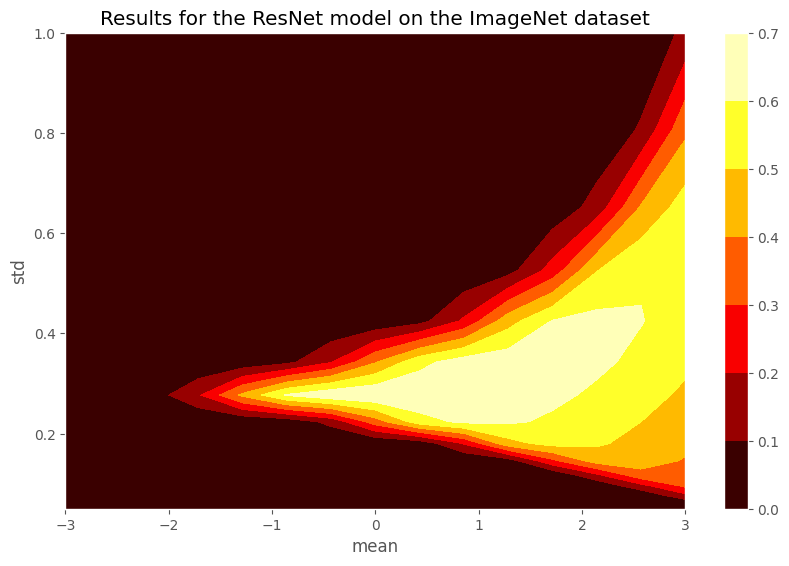

In [39]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

Let's zoom around the central region

In [40]:
N_scan = 15
means = np.linspace(-.5, 1.5, N_scan, endpoint=True)
stds = np.geomspace(0.20, 0.6, N_scan, endpoint=True)

path_save_numpy =  f'numpy-{model}-zoom.npy'
if not(os.path.isfile(path_save_numpy)):
    accuracy = np.empty((N_scan, N_scan))
    for i_mean, mean in enumerate(means):
        for i_std, std in enumerate(stds):
            accuracy[i_mean, i_std] = main(mean, mean, mean, std, std, std, epochs=epochs)

    np.save(path_save_numpy, accuracy)
else:
    accuracy = np.load(path_save_numpy)

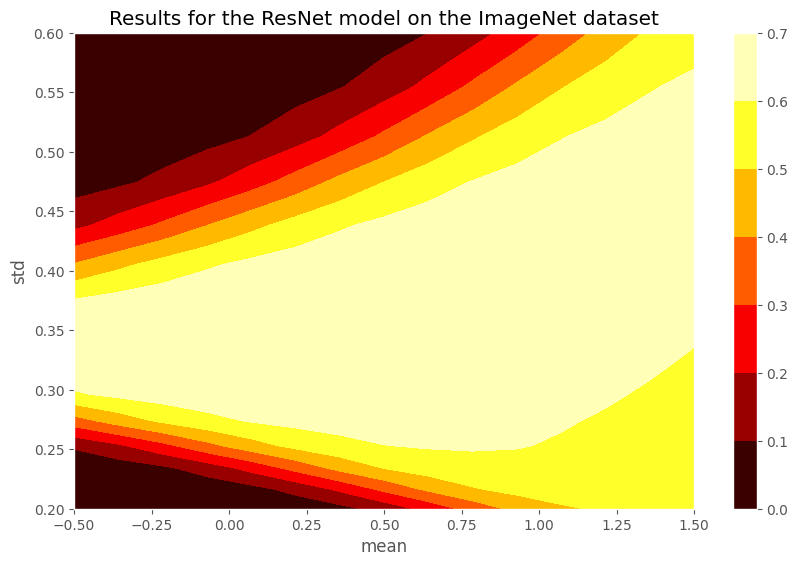

In [41]:
fig, ax = plt.subplots(figsize=figsize)
pcm = ax.contourf(means, stds, accuracy, cmap='hot')
fig.colorbar(pcm, ax=ax)
ax.set_title('Results for the ResNet model on the ImageNet dataset')
ax.set_xlabel('mean')
ax.set_ylabel('std')
fig;

### using optuna to search for another initialization point


And now with optuna:

In [42]:
path_save_optuna =  f'optuna-{model}.sqlite3'

In [43]:
# %rm {path_save_optuna}

In [44]:
def objective(trial):
    mean = trial.suggest_float('mean', -.5, 1.5, log=False)
    std = trial.suggest_float('std', 0.20, 0.6, log=True)
    accuracy = main(mean, mean, mean, std, std, std, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model)
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean': 0.45813765422778663, 'std': 0.23579097981269004}
Best value:  0.69398


In [45]:
path_save_optuna, len(study.get_trials())

('optuna-ResNet.sqlite3', 200)

In [46]:
study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)

/tmp/ipykernel_531714/1797386942.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
[W 2024-12-28 10:47:50,910] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


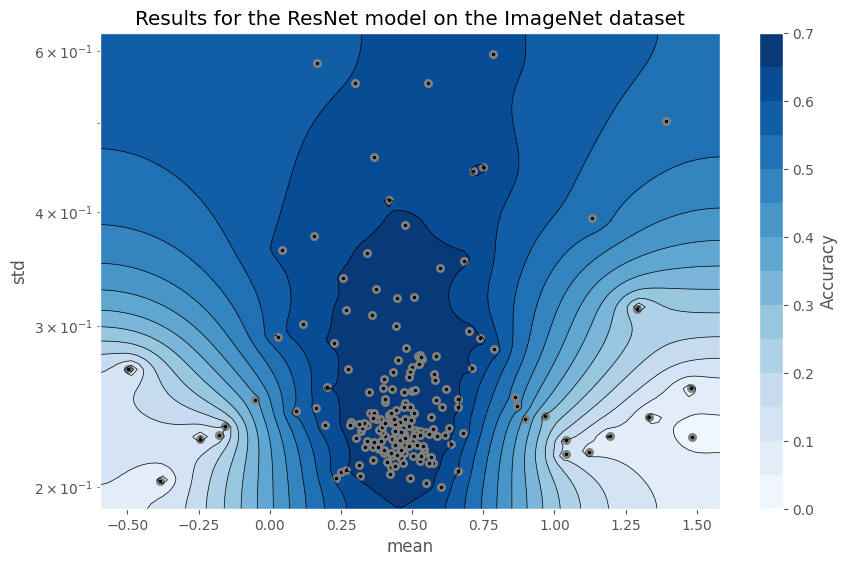

In [47]:
# https://optuna.readthedocs.io/en/stable/reference/visualization/matplotlib/generated/optuna.visualization.matplotlib.contour.html
from optuna.visualization.matplotlib import plot_contour

ax = plot_contour(study, params=["mean", "std"], target_name="Accuracy")
ax.set_title('Results for the ResNet model on the ImageNet dataset')
fig = plt.gcf()
fig.set_size_inches(figsize[0], figsize[1])

### Appendix : looking for optimal values in RGB space

We can further explore the 6-dimensional space:


In [48]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', -1, 2., log=False)
    mean_G = trial.suggest_float('mean_G', -1, 2., log=False)
    mean_B = trial.suggest_float('mean_B', -1, 2., log=False)
    std_R = trial.suggest_float('std_R', 0.05, 1., log=True)
    std_G = trial.suggest_float('std_G', 0.05, 1., log=True)
    std_B = trial.suggest_float('std_B', 0.05, 1., log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean_R': 0.5759977076117301, 'mean_G': 0.6686394118656815, 'mean_B': 0.7427398194700434, 'std_R': 0.30742014985012184, 'std_G': 0.36756360234262425, 'std_B': 0.4110226547110426}
Best value:  0.66928


In [49]:
def objective(trial):
    mean_R = trial.suggest_float('mean_R', .40, .60, log=False)
    mean_G = trial.suggest_float('mean_G', .40, .60, log=False)
    mean_B = trial.suggest_float('mean_B', .40, .60, log=False)
    std_R = trial.suggest_float('std_R', .15, .35, log=True)
    std_G = trial.suggest_float('std_G', .15, .35, log=True)
    std_B = trial.suggest_float('std_B', .15, .35, log=True)
    accuracy = main(mean_R, mean_G, mean_B, std_R, std_G, std_B, epochs=epochs)
    return accuracy

study = optuna.create_study(direction='maximize', load_if_exists=True, 
                            storage=f"sqlite:///{path_save_optuna}", study_name=model + '-RGB_fine')
if len(study.get_trials())<n_trials:
    study.optimize(objective, n_trials=n_trials-len(study.get_trials()), show_progress_bar=True)
print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print(50*'=')

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Best params:  {'mean_R': 0.46310177333629443, 'mean_G': 0.470980296382525, 'mean_B': 0.5076892083068535, 'std_R': 0.23876253734074915, 'std_G': 0.23201577544899127, 'std_B': 0.2834836298850044}
Best value:  0.6961


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,192] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,240] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,285] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,331] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,377] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,424] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,469] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,516] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


/tmp/ipykernel_531714/2577725987.py:4: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
[W 2024-12-28 10:47:51,562] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


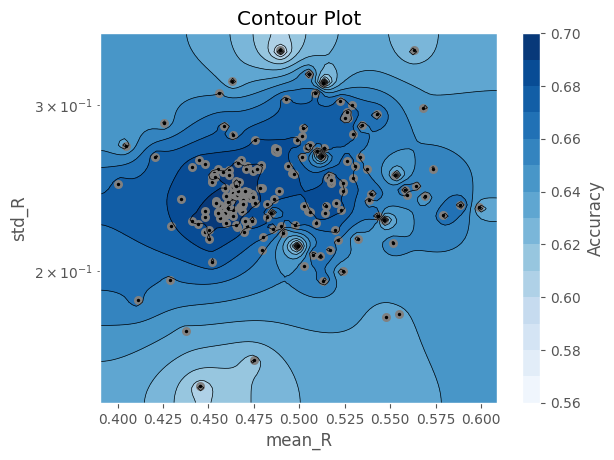

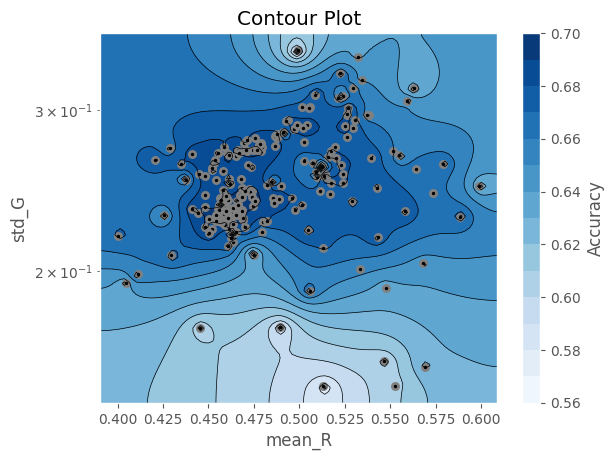

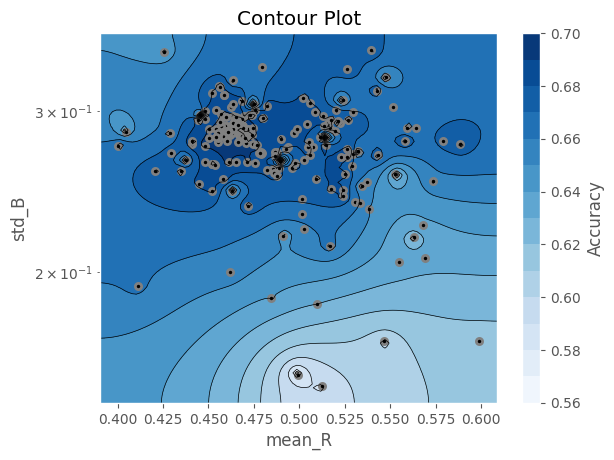

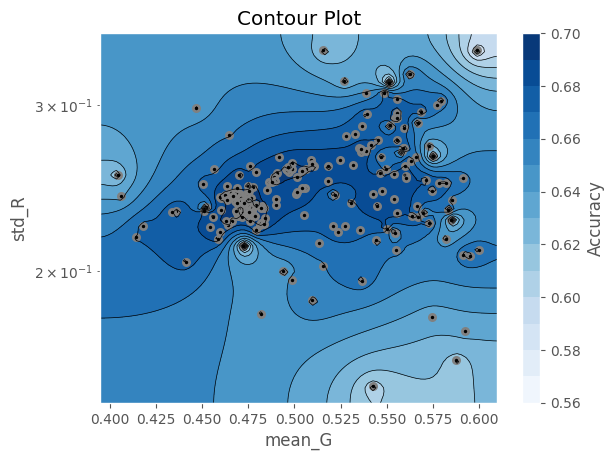

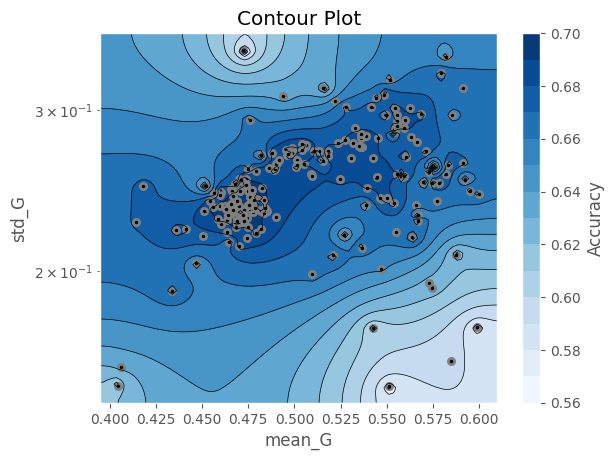

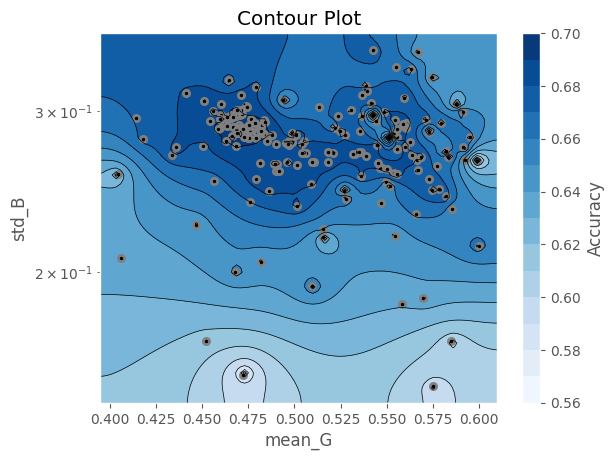

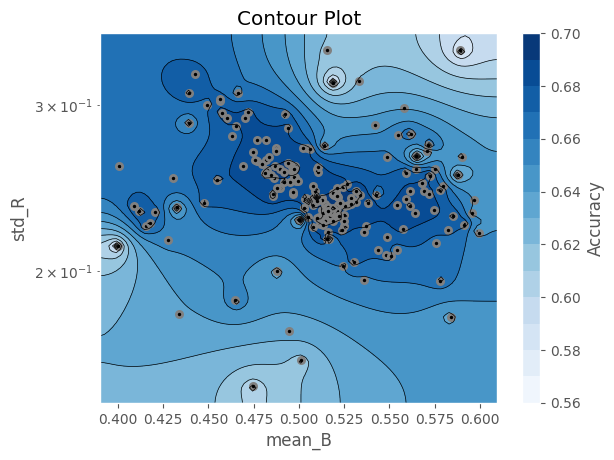

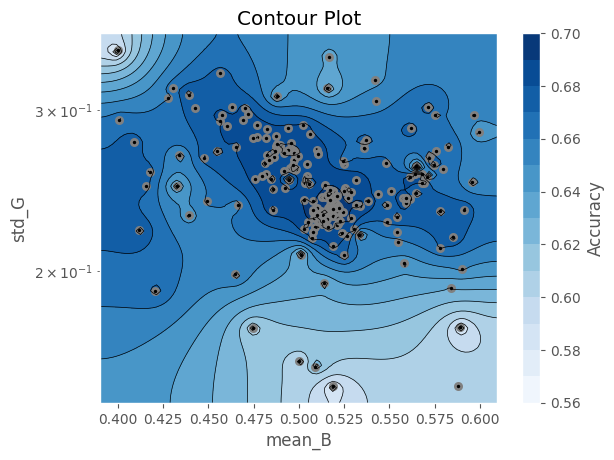

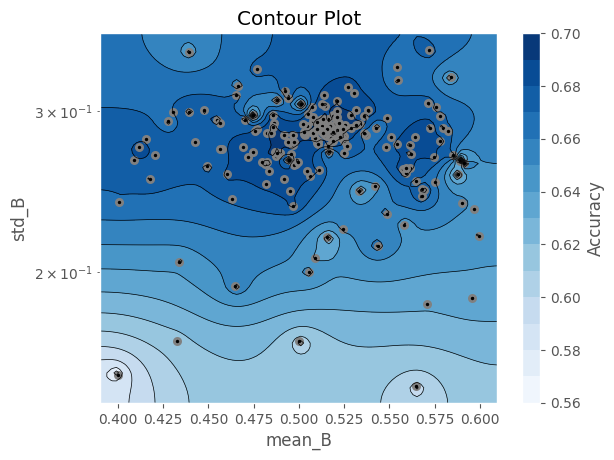

In [50]:
# fig, axs = plt.subplots(3, 3, figsize=figsize)
for i, c_mean in enumerate(['R', 'G', 'B']):
    for j, c_std in enumerate(['R', 'G', 'B']):
        ax = plot_contour(study, params=["mean_" + c_mean, "std_" + c_std], target_name="Accuracy")
        # ax.set_title('Results for the ResNet model on the ImageNet dataset')

/tmp/ipykernel_531714/2013726993.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])


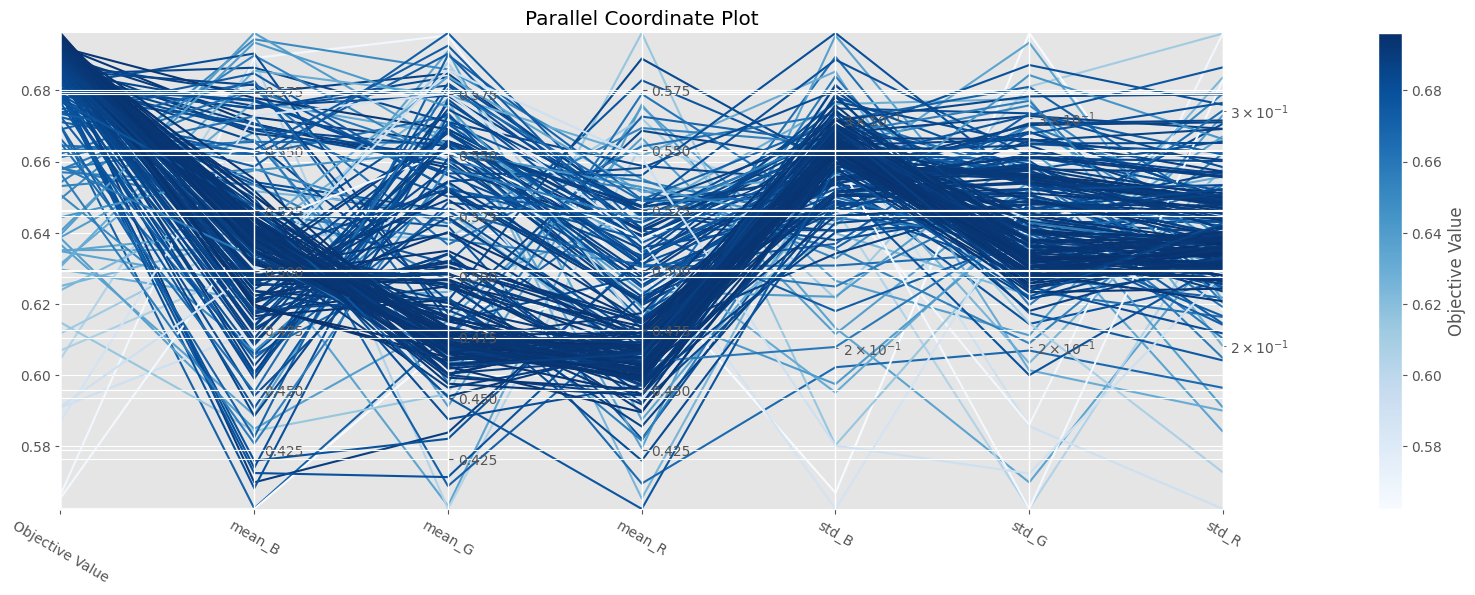

In [51]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["mean_R", "mean_G", "mean_B", "std_R", "std_G", "std_B"])
plt.gcf().set_size_inches(figsize[0]*2, figsize[1])

## some book keeping for the notebook

In [52]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,torch  -r -g -b

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.31.0

numpy     : 1.26.4
matplotlib: 3.10.0
torch     : 2.5.1

Compiler    : GCC 14.2.0
OS          : Linux
Release     : 6.11.0-13-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 24
Architecture: 64bit

Hostname: CONECT-LID-01

Git hash: 2d68b74929f8b4d0e93bcbeb9a9a1bb05fa56422

Git repo: https://github.com/laurentperrinet/2024-12-09-normalizing-images-in-convolutional-neural-networks.git

Git branch: main

